In [1]:
# %%
# 导入基础库
import os
import time
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# 导入PyTorch相关库
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import models, transforms, datasets
from torchvision.models import ResNet18_Weights

# 设置随机种子，确保可复现性
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# 设备设置
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用设备: {device}")

# 检查CUDA设备
if torch.cuda.is_available():
    print(f"当前CUDA设备: {torch.cuda.get_device_name(0)}")
    print(f"CUDA版本: {torch.version.cuda}")


使用设备: cuda
当前CUDA设备: NVIDIA GeForce RTX 3090
CUDA版本: 11.8


In [2]:
# %%
# 项目配置
class Config:
    # 数据集配置
    DATA_PATH = '/mnt/MCP/hagrid_classification'
    CLASSES = ['call', 'fist', 'like', 'ok', 'one', 'palm', 'rock', 'three', 'two_up']
    NUM_CLASSES = len(CLASSES)
    
    # 模型配置
    MODEL_NAME = 'ResNet18'
    INPUT_SIZE = (3, 224, 224)
    USE_PRETRAINED = True
    
    # 训练配置
    BATCH_SIZE = 32
    NUM_EPOCHS = 100
    LEARNING_RATE = 0.001
    WEIGHT_DECAY = 0.001
    NUM_WORKERS = 4
    
    # 早停配置
    PATIENCE = 15
    MIN_DELTA = 0.001
    
    # 模型保存路径
    MODEL_SAVE_DIR = './models'
    BEST_MODEL_PATH = os.path.join(MODEL_SAVE_DIR, 'best_resnet18_gesture_model.pth')
    FINAL_MODEL_PATH = os.path.join(MODEL_SAVE_DIR, 'final_resnet18_gesture_model.pth')

# 创建保存模型的目录
if not os.path.exists(Config.MODEL_SAVE_DIR):
    os.makedirs(Config.MODEL_SAVE_DIR)

# 检查数据集路径是否存在
if not os.path.exists(Config.DATA_PATH):
    print(f"警告: 数据路径 {Config.DATA_PATH} 不存在，请确认数据集路径！")
else:
    print(f"数据集路径已确认: {Config.DATA_PATH}")
    train_dir = os.path.join(Config.DATA_PATH, 'train')
    val_dir = os.path.join(Config.DATA_PATH, 'val')
    
    if os.path.exists(train_dir):
        print(f"训练集目录: {train_dir}")
    if os.path.exists(val_dir):
        print(f"验证集目录: {val_dir}")


数据集路径已确认: /mnt/MCP/hagrid_classification
训练集目录: /mnt/MCP/hagrid_classification/train
验证集目录: /mnt/MCP/hagrid_classification/val


In [3]:
import matplotlib.pyplot as plt

# 设置支持中文的字体（根据系统已安装的字体选择）
plt.rcParams["font.family"] = ["SimHei", "WenQuanYi Micro Hei", "Heiti TC"]  # 黑体、文泉驿微米黑、 Heiiti TC（macOS）

训练集大小: 204187
验证集大小: 26990
类别映射: {'call': 0, 'fist': 1, 'like': 2, 'ok': 3, 'one': 4, 'palm': 5, 'rock': 6, 'three': 7, 'two_up': 8}


findfont: Font family 'SimHei' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Fon

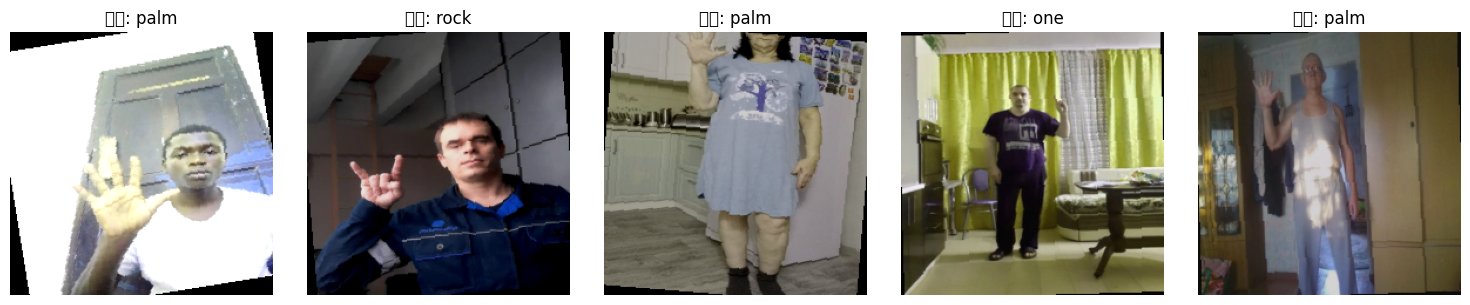

In [4]:
# %%
# 定义数据增强和转换
def get_data_transforms():
    """
    创建训练和验证数据集的转换流水线
    
    返回:
        train_transforms, val_transforms: 两个转换对象
    """
    # 标准ImageNet均值和标准差
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    
    # 训练数据增强：提高模型泛化能力
    train_transforms = transforms.Compose([
        transforms.Resize((256, 256)),       # 调整大小以便后续裁剪
        transforms.RandomCrop(224),          # 随机裁剪以增加位置不变性
        transforms.RandomHorizontalFlip(p=0.5),  # 随机水平翻转
        transforms.RandomRotation(10),       # 小角度旋转
        transforms.ColorJitter(              # 颜色变换
            brightness=0.2,                  # 亮度变化
            contrast=0.2,                    # 对比度变化
            saturation=0.2,                  # 饱和度变化
            hue=0.1                          # 色调变化
        ),
        transforms.ToTensor(),               # 转换为Tensor
        transforms.Normalize(mean=mean, std=std)  # 标准化
    ])
    
    # 验证数据转换：只需调整大小和标准化
    val_transforms = transforms.Compose([
        transforms.Resize((256, 256)),       # 调整大小
        transforms.CenterCrop(224),          # 中心裁剪，保持一致
        transforms.ToTensor(),               # 转换为Tensor
        transforms.Normalize(mean=mean, std=std)  # 标准化
    ])
    
    return train_transforms, val_transforms

# 加载并预处理数据集
def load_datasets():
    """
    加载并预处理训练集和验证集
    
    返回:
        train_dataset, val_dataset: 两个数据集对象
    """
    # 获取数据转换
    train_transforms, val_transforms = get_data_transforms()
    
    # 加载数据集
    train_dataset = datasets.ImageFolder(
        root=os.path.join(Config.DATA_PATH, 'train'),
        transform=train_transforms
    )
    
    val_dataset = datasets.ImageFolder(
        root=os.path.join(Config.DATA_PATH, 'val'),
        transform=val_transforms
    )
    
    # 输出数据集信息
    print(f"训练集大小: {len(train_dataset)}")
    print(f"验证集大小: {len(val_dataset)}")
    print(f"类别映射: {train_dataset.class_to_idx}")
    
    return train_dataset, val_dataset

# 创建数据加载器
def create_data_loaders(train_dataset, val_dataset):
    """
    为训练集和验证集创建数据加载器
    
    参数:
        train_dataset: 训练数据集
        val_dataset: 验证数据集
    返回:
        train_loader, val_loader: 两个数据加载器
    """
    train_loader = DataLoader(
        train_dataset,
        batch_size=Config.BATCH_SIZE,
        shuffle=True,
        num_workers=Config.NUM_WORKERS,
        pin_memory=True
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=Config.BATCH_SIZE,
        shuffle=False,
        num_workers=Config.NUM_WORKERS,
        pin_memory=True
    )
    
    return train_loader, val_loader

# 执行数据加载
train_dataset, val_dataset = load_datasets()
train_loader, val_loader = create_data_loaders(train_dataset, val_dataset)

# 可视化一些训练样本
def visualize_samples(dataset, num_samples=5):
    """可视化数据集的样本"""
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    
    # 反标准化函数
    def denormalize(tensor):
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        return torch.clamp(tensor * std + mean, 0, 1)
    
    for i in range(num_samples):
        # 随机选择样本
        idx = np.random.randint(0, len(dataset))
        img, label = dataset[idx]
        
        # 反标准化图像
        img = denormalize(img)
        
        # 显示图像
        axes[i].imshow(img.permute(1, 2, 0))
        axes[i].set_title(f"类别: {Config.CLASSES[label]}")
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# 可视化一些样本
visualize_samples(train_dataset)


In [5]:
# %%
# 定义手势识别模型类
class GestureResNet(nn.Module):
    """基于ResNet18的手势识别模型"""
    
    def __init__(self, num_classes=9, use_pretrained=True):
        """
        初始化手势识别模型
        
        参数:
            num_classes (int): 类别数量
            use_pretrained (bool): 是否使用预训练权重
        """
        super(GestureResNet, self).__init__()
        
        # 加载预训练的ResNet18模型
        if use_pretrained:
            # 使用正确的预训练权重格式
            weights = ResNet18_Weights.IMAGENET1K_V1
            self.model = models.resnet18(weights=weights)
            print("加载预训练的ResNet18模型（ImageNet权重）")
        else:
            self.model = models.resnet18(weights=None)
            print("初始化ResNet18模型（无预训练权重）")
            
        # 修改最后的全连接层以匹配我们的类别数
        in_features = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Dropout(0.2),  # 添加Dropout以减少过拟合
            nn.Linear(in_features, num_classes)
        )
    
    def forward(self, x):
        """前向传播"""
        return self.model(x)

# 初始化模型
def initialize_model():
    """
    初始化并配置手势识别模型
    
    返回:
        model: 配置好的模型
    """
    # 创建模型
    model = GestureResNet(
        num_classes=Config.NUM_CLASSES,
        use_pretrained=Config.USE_PRETRAINED
    )
    
    # 将模型移到指定设备
    model = model.to(device)
    
    # 统计模型参数
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f"总参数量: {total_params:,}")
    print(f"可训练参数量: {trainable_params:,}")
    
    return model

# 初始化模型
model = initialize_model()

# 打印模型架构
print(model)


加载预训练的ResNet18模型（ImageNet权重）
总参数量: 11,181,129
可训练参数量: 11,181,129
GestureResNet(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (

In [6]:
# %%
# 定义损失函数和优化器
def configure_training(model):
    """
    配置训练所需的损失函数、优化器和学习率调度器
    
    参数:
        model: 要训练的模型
    返回:
        criterion, optimizer, scheduler: 损失函数、优化器和学习率调度器
    """
    # 损失函数：交叉熵损失（适用于多分类问题）
    criterion = nn.CrossEntropyLoss()
    
    # 优化器：Adam优化器，具有权重衰减（L2正则化）
    optimizer = optim.Adam(
        model.parameters(),
        lr=Config.LEARNING_RATE,
        weight_decay=Config.WEIGHT_DECAY
    )
    
    # 学习率调度器：余弦退火，随着训练的进行逐渐降低学习率
    scheduler = CosineAnnealingLR(
        optimizer,
        T_max=Config.NUM_EPOCHS
    )
    
    return criterion, optimizer, scheduler

# 配置训练组件
criterion, optimizer, scheduler = configure_training(model)

# 定义早停机制
class EarlyStopping:
    """早停机制，防止过拟合"""
    
    def __init__(self, patience=15, min_delta=0.001):
        """
        初始化早停对象
        
        参数:
            patience (int): 容忍的epoch数
            min_delta (float): 最小改善阈值
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
    
    def __call__(self, val_loss):
        """
        调用以更新早停状态
        
        参数:
            val_loss (float): 当前验证损失
        """
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# 初始化早停机制
early_stopping = EarlyStopping(
    patience=Config.PATIENCE,
    min_delta=Config.MIN_DELTA
)


In [7]:
# %%
# 训练和验证函数
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    """
    训练模型一个epoch
    
    参数:
        model: 模型
        dataloader: 训练数据加载器
        criterion: 损失函数
        optimizer: 优化器
        device: 计算设备
    
    返回:
        epoch_loss, epoch_acc: 该epoch的平均损失和准确率
    """
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # 使用tqdm显示进度条
    pbar = tqdm(dataloader, desc="训练中")
    
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # 梯度清零
        optimizer.zero_grad()
        
        # 前向传播
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # 反向传播
        loss.backward()
        
        # 参数更新
        optimizer.step()
        
        # 累计损失
        running_loss += loss.item() * inputs.size(0)
        
        # 计算准确率
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # 更新进度条
        pbar.set_postfix({
            'loss': loss.item(),
            'acc': correct / total
        })
    
    # 计算整个epoch的平均损失和准确率
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = correct / total
    
    return epoch_loss, epoch_acc

def validate(model, dataloader, criterion, device):
    """
    验证模型性能
    
    参数:
        model: 模型
        dataloader: 验证数据加载器
        criterion: 损失函数
        device: 计算设备
    
    返回:
        val_loss, val_acc: 验证损失和准确率
    """
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="验证中"):
            inputs, labels = inputs.to(device), labels.to(device)
            
            # 前向传播
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # 累计损失
            running_loss += loss.item() * inputs.size(0)
            
            # 计算准确率
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # 保存预测结果和标签，用于后续计算指标
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # 计算整体验证损失和准确率
    val_loss = running_loss / len(dataloader.dataset)
    val_acc = correct / total
    
    return val_loss, val_acc, all_preds, all_labels


In [ ]:
# %%
# 训练循环
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs):
    """
    训练模型的主循环
    
    参数:
        model: 要训练的模型
        train_loader: 训练数据加载器
        val_loader: 验证数据加载器
        criterion: 损失函数
        optimizer: 优化器
        scheduler: 学习率调度器
        num_epochs: 训练轮数
    
    返回:
        history: 包含训练和验证指标的历史记录
    """
    # 创建训练历史记录
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'best_epoch': 0,
        'best_val_acc': 0.0
    }
    
    # 训练开始时间
    start_time = time.time()
    
    # 最佳模型保存
    best_val_acc = 0.0
    
    # 训练循环
    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        
        # 训练一个epoch
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        
        # 验证
        val_loss, val_acc, _, _ = validate(model, val_loader, criterion, device)
        
        # 学习率调整
        scheduler.step()
        
        # 记录历史
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        # 输出当前epoch训练情况
        epoch_time = time.time() - epoch_start_time
        print(f"\nEpoch {epoch+1}/{num_epochs} 完成")
        print(f"训练损失: {train_loss:.4f} | 训练准确率: {train_acc:.4f}")
        print(f"验证损失: {val_loss:.4f} | 验证准确率: {val_acc:.4f}")
        print(f"当前学习率: {optimizer.param_groups[0]['lr']:.6f}")
        print(f"本轮用时: {epoch_time:.2f}秒")
        
        # 保存最佳模型
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            history['best_val_acc'] = best_val_acc
            history['best_epoch'] = epoch + 1
            
            torch.save(model.state_dict(), Config.BEST_MODEL_PATH)
            print(f"✓ 模型已保存为 {Config.BEST_MODEL_PATH} (验证准确率提高: {best_val_acc:.4f})")
        
        # 早停检查
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print(f"\n早停机制触发，在Epoch {epoch+1}停止训练")
            break
    
    # 训练结束时间
    total_time = time.time() - start_time
    hours, remainder = divmod(total_time, 3600)
    minutes, seconds = divmod(remainder, 60)
    print(f"\n训练完成! 总用时: {int(hours)}小时 {int(minutes)}分钟 {int(seconds)}秒")
    print(f"最佳验证准确率: {best_val_acc:.4f} (在Epoch {history['best_epoch']})")
    
    # 保存最终模型
    torch.save(model.state_dict(), Config.FINAL_MODEL_PATH)
    print(f"最终模型已保存为 {Config.FINAL_MODEL_PATH}")
    
    return history

# 执行训练
training_history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=Config.NUM_EPOCHS
)

# 可视化训练历史
def plot_training_history(history):
    """绘制训练和验证的损失和准确率曲线"""
    plt.figure(figsize=(12, 5))
    
    # 绘制损失曲线
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='训练损失')
    plt.plot(history['val_loss'], label='验证损失')
    plt.xlabel('Epoch')
    plt.ylabel('损失')
    plt.title('训练和验证损失')
    plt.legend()
    plt.grid(True)
    
    # 绘制准确率曲线
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='训练准确率')
    plt.plot(history['val_acc'], label='验证准确率')
    plt.xlabel('Epoch')
    plt.ylabel('准确率')
    plt.title('训练和验证准确率')
    plt.legend()
    plt.grid(True)
    
    # 标记最佳epoch
    best_epoch = history['best_epoch'] - 1
    plt.axvline(x=best_epoch, color='r', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()

# 可视化训练历史
plot_training_history(training_history)


训练中:   0%|          | 0/6381 [00:00<?, ?it/s]

验证中:   0%|          | 0/844 [00:00<?, ?it/s]


Epoch 1/100 完成
训练损失: 0.6124 | 训练准确率: 0.8005
验证损失: 0.4178 | 验证准确率: 0.8634
当前学习率: 0.001000
本轮用时: 699.90秒
✓ 模型已保存为 ./models/best_resnet18_gesture_model.pth (验证准确率提高: 0.8634)


训练中:   0%|          | 0/6381 [00:00<?, ?it/s]

验证中:   0%|          | 0/844 [00:00<?, ?it/s]


Epoch 2/100 完成
训练损失: 0.4351 | 训练准确率: 0.8631
验证损失: 0.3828 | 验证准确率: 0.8794
当前学习率: 0.000999
本轮用时: 692.74秒
✓ 模型已保存为 ./models/best_resnet18_gesture_model.pth (验证准确率提高: 0.8794)


训练中:   0%|          | 0/6381 [00:00<?, ?it/s]

验证中:   0%|          | 0/844 [00:00<?, ?it/s]


Epoch 3/100 完成
训练损失: 0.4041 | 训练准确率: 0.8729
验证损失: 0.3401 | 验证准确率: 0.8906
当前学习率: 0.000998
本轮用时: 693.11秒
✓ 模型已保存为 ./models/best_resnet18_gesture_model.pth (验证准确率提高: 0.8906)


训练中:   0%|          | 0/6381 [00:00<?, ?it/s]

验证中:   0%|          | 0/844 [00:00<?, ?it/s]


Epoch 4/100 完成
训练损失: 0.3918 | 训练准确率: 0.8772
验证损失: 0.3132 | 验证准确率: 0.8987
当前学习率: 0.000996
本轮用时: 689.78秒
✓ 模型已保存为 ./models/best_resnet18_gesture_model.pth (验证准确率提高: 0.8987)


训练中:   0%|          | 0/6381 [00:00<?, ?it/s]

验证中:   0%|          | 0/844 [00:00<?, ?it/s]


Epoch 5/100 完成
训练损失: 0.3860 | 训练准确率: 0.8793
验证损失: 0.3074 | 验证准确率: 0.9059
当前学习率: 0.000994
本轮用时: 689.74秒
✓ 模型已保存为 ./models/best_resnet18_gesture_model.pth (验证准确率提高: 0.9059)


训练中:   0%|          | 0/6381 [00:00<?, ?it/s]

验证中:   0%|          | 0/844 [00:00<?, ?it/s]


Epoch 6/100 完成
训练损失: 0.3830 | 训练准确率: 0.8804
验证损失: 0.2990 | 验证准确率: 0.9052
当前学习率: 0.000991
本轮用时: 700.68秒


训练中:   0%|          | 0/6381 [00:00<?, ?it/s]

验证中:   0%|          | 0/844 [00:00<?, ?it/s]


Epoch 7/100 完成
训练损失: 0.3745 | 训练准确率: 0.8825
验证损失: 0.3586 | 验证准确率: 0.8875
当前学习率: 0.000988
本轮用时: 698.81秒


训练中:   0%|          | 0/6381 [00:00<?, ?it/s]

验证中:   0%|          | 0/844 [00:00<?, ?it/s]


Epoch 8/100 完成
训练损失: 0.3766 | 训练准确率: 0.8825
验证损失: 0.3828 | 验证准确率: 0.8765
当前学习率: 0.000984
本轮用时: 696.25秒


训练中:   0%|          | 0/6381 [00:00<?, ?it/s]

验证中:   0%|          | 0/844 [00:00<?, ?it/s]


Epoch 9/100 完成
训练损失: 0.3677 | 训练准确率: 0.8854
验证损失: 0.3097 | 验证准确率: 0.9013
当前学习率: 0.000980
本轮用时: 690.75秒


训练中:   0%|          | 0/6381 [00:00<?, ?it/s]

验证中:   0%|          | 0/844 [00:00<?, ?it/s]


Epoch 10/100 完成
训练损失: 0.3656 | 训练准确率: 0.8859
验证损失: 0.3751 | 验证准确率: 0.8832
当前学习率: 0.000976
本轮用时: 704.82秒


训练中:   0%|          | 0/6381 [00:00<?, ?it/s]

验证中:   0%|          | 0/844 [00:00<?, ?it/s]


Epoch 11/100 完成
训练损失: 0.3669 | 训练准确率: 0.8856
验证损失: 0.2586 | 验证准确率: 0.9185
当前学习率: 0.000970
本轮用时: 700.41秒
✓ 模型已保存为 ./models/best_resnet18_gesture_model.pth (验证准确率提高: 0.9185)


训练中:   0%|          | 0/6381 [00:00<?, ?it/s]

验证中:   0%|          | 0/844 [00:00<?, ?it/s]


Epoch 12/100 完成
训练损失: 0.3645 | 训练准确率: 0.8865
验证损失: 0.3078 | 验证准确率: 0.9010
当前学习率: 0.000965
本轮用时: 698.26秒


训练中:   0%|          | 0/6381 [00:00<?, ?it/s]

验证中:   0%|          | 0/844 [00:00<?, ?it/s]


Epoch 13/100 完成
训练损失: 0.3618 | 训练准确率: 0.8875
验证损失: 0.3045 | 验证准确率: 0.9034
当前学习率: 0.000959
本轮用时: 699.40秒


训练中:   0%|          | 0/6381 [00:00<?, ?it/s]

验证中:   0%|          | 0/844 [00:00<?, ?it/s]


Epoch 14/100 完成
训练损失: 0.3605 | 训练准确率: 0.8880
验证损失: 0.3536 | 验证准确率: 0.8860
当前学习率: 0.000952
本轮用时: 692.09秒


训练中:   0%|          | 0/6381 [00:00<?, ?it/s]

验证中:   0%|          | 0/844 [00:00<?, ?it/s]


Epoch 15/100 完成
训练损失: 0.3565 | 训练准确率: 0.8886
验证损失: 0.2882 | 验证准确率: 0.9112
当前学习率: 0.000946
本轮用时: 707.26秒


训练中:   0%|          | 0/6381 [00:00<?, ?it/s]

验证中:   0%|          | 0/844 [00:00<?, ?it/s]


Epoch 16/100 完成
训练损失: 0.3530 | 训练准确率: 0.8905
验证损失: 0.3656 | 验证准确率: 0.8810
当前学习率: 0.000938
本轮用时: 703.82秒


训练中:   0%|          | 0/6381 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



验证中:   0%|          | 0/844 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



验证中:   0%|          | 0/844 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



验证中:   0%|          | 0/844 [00:00<?, ?it/s]


Epoch 22/100 完成
训练损失: 0.3416 | 训练准确率: 0.8940
验证损失: 0.2798 | 验证准确率: 0.9116
当前学习率: 0.000885
本轮用时: 705.08秒


训练中:   0%|          | 0/6381 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)




Epoch 23/100 完成
训练损失: 0.3411 | 训练准确率: 0.8941
验证损失: 0.2882 | 验证准确率: 0.9105
当前学习率: 0.000875
本轮用时: 721.21秒


训练中:   0%|          | 0/6381 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)




Epoch 24/100 完成
训练损失: 0.3414 | 训练准确率: 0.8934
验证损失: 0.2713 | 验证准确率: 0.9147
当前学习率: 0.000864
本轮用时: 716.89秒


训练中:   0%|          | 0/6381 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)




Epoch 25/100 完成
训练损失: 0.3379 | 训练准确率: 0.8953
验证损失: 0.2731 | 验证准确率: 0.9130
当前学习率: 0.000854
本轮用时: 694.00秒


训练中:   0%|          | 0/6381 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter serve

验证中:   0%|          | 0/844 [00:00<?, ?it/s]


Epoch 30/100 完成
训练损失: 0.3217 | 训练准确率: 0.9001
验证损失: 0.2349 | 验证准确率: 0.9250
当前学习率: 0.000794
本轮用时: 713.06秒
✓ 模型已保存为 ./models/best_resnet18_gesture_model.pth (验证准确率提高: 0.9250)


训练中:   0%|          | 0/6381 [00:00<?, ?it/s]

验证中:   0%|          | 0/844 [00:00<?, ?it/s]


Epoch 31/100 完成
训练损失: 0.3207 | 训练准确率: 0.9006
验证损失: 0.2644 | 验证准确率: 0.9155
当前学习率: 0.000781
本轮用时: 699.38秒


训练中:   0%|          | 0/6381 [00:00<?, ?it/s]

验证中:   0%|          | 0/844 [00:00<?, ?it/s]


Epoch 32/100 完成
训练损失: 0.3187 | 训练准确率: 0.9012
验证损失: 0.2660 | 验证准确率: 0.9150
当前学习率: 0.000768
本轮用时: 698.75秒


训练中:   0%|          | 0/6381 [00:00<?, ?it/s]

验证中:   0%|          | 0/844 [00:00<?, ?it/s]


Epoch 33/100 完成
训练损失: 0.3145 | 训练准确率: 0.9022
验证损失: 0.3028 | 验证准确率: 0.9027
当前学习率: 0.000755
本轮用时: 692.63秒


训练中:   0%|          | 0/6381 [00:00<?, ?it/s]

验证中:   0%|          | 0/844 [00:00<?, ?it/s]


Epoch 34/100 完成
训练损失: 0.3124 | 训练准确率: 0.9030
验证损失: 0.2740 | 验证准确率: 0.9123
当前学习率: 0.000741
本轮用时: 697.06秒


训练中:   0%|          | 0/6381 [00:00<?, ?it/s]

验证中:   0%|          | 0/844 [00:00<?, ?it/s]


Epoch 35/100 完成
训练损失: 0.3099 | 训练准确率: 0.9043
验证损失: 0.2545 | 验证准确率: 0.9177
当前学习率: 0.000727
本轮用时: 697.00秒


训练中:   0%|          | 0/6381 [00:00<?, ?it/s]

验证中:   0%|          | 0/844 [00:00<?, ?it/s]


Epoch 36/100 完成
训练损失: 0.3064 | 训练准确率: 0.9051
验证损失: 0.2510 | 验证准确率: 0.9199
当前学习率: 0.000713
本轮用时: 712.04秒


训练中:   0%|          | 0/6381 [00:00<?, ?it/s]

开始模型评估...


验证中:   0%|          | 0/844 [00:00<?, ?it/s]

findfont: Font family 'SimHei' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Fon


===== 模型评估结果 =====
准确率 (Accuracy): 0.9758
精确率 (Precision): 0.9758
召回率 (Recall): 0.9758
F1值 (F1 Score): 0.9758

各类别指标:
       类别       精确率       召回率       F1值
0    call  0.981946  0.979000  0.980471
1    fist  0.981038  0.983328  0.982182
2    like  0.966667  0.976659  0.971637
3      ok  0.976698  0.978326  0.977511
4     one  0.956478  0.959667  0.958070
5    palm  0.986970  0.984995  0.985981
6    rock  0.977433  0.968302  0.972846
7   three  0.979361  0.981321  0.980340
8  two_up  0.975863  0.970657  0.973253


findfont: Font family 'Heiti TC' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Fon

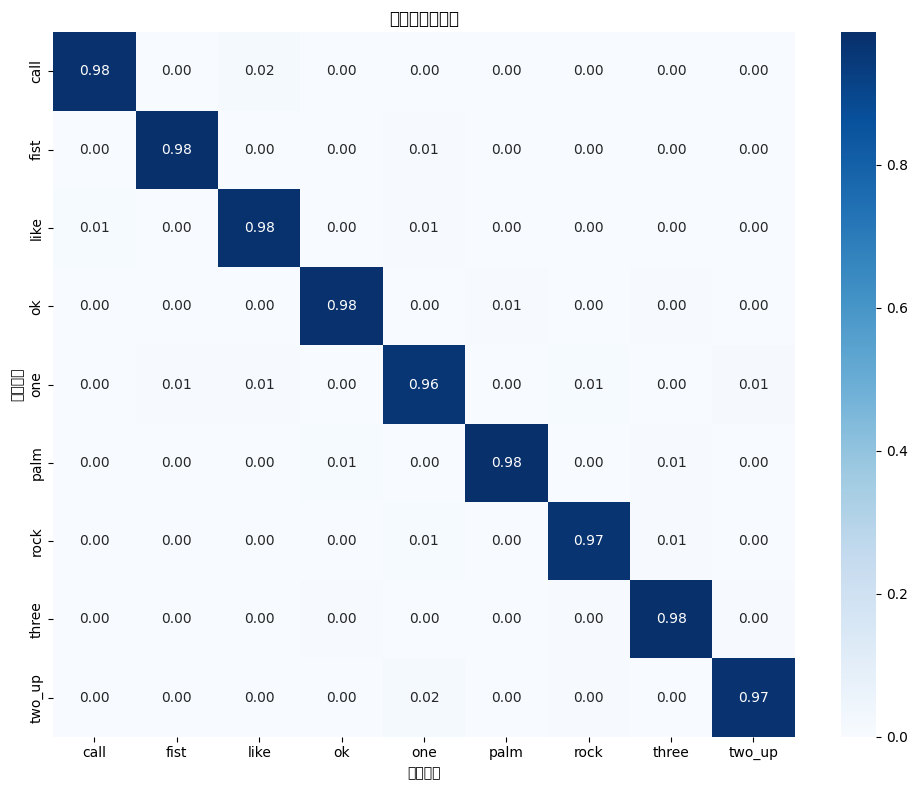

findfont: Font family 'SimHei' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Fon

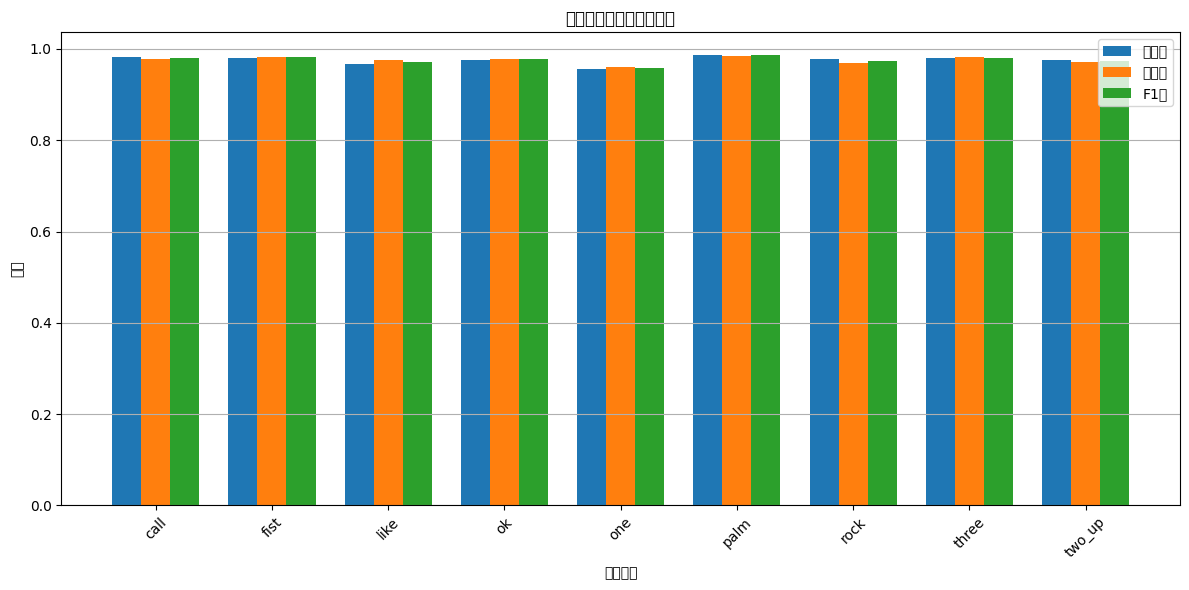

In [9]:
# %%
# 模型评估
def evaluate_model(model, dataloader, criterion, device):
    """
    全面评估模型性能
    
    参数:
        model: 要评估的模型
        dataloader: 数据加载器
        criterion: 损失函数
        device: 计算设备
    
    返回:
        评估指标和预测结果
    """
    print("开始模型评估...")
    
    # 加载最佳模型
    model.load_state_dict(torch.load(Config.BEST_MODEL_PATH))
    model.eval()
    
    # 获取验证集上的损失、准确率和预测
    val_loss, val_acc, all_preds, all_labels = validate(model, dataloader, criterion, device)
    
    # 计算评估指标
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    # 输出评估结果
    print("\n===== 模型评估结果 =====")
    print(f"准确率 (Accuracy): {accuracy:.4f}")
    print(f"精确率 (Precision): {precision:.4f}")
    print(f"召回率 (Recall): {recall:.4f}")
    print(f"F1值 (F1 Score): {f1:.4f}")
    
    # 计算混淆矩阵
    cm = confusion_matrix(all_labels, all_preds)
    
    # 每个类别的精确率、召回率和F1值
    print("\n各类别指标:")
    precision_per_class = precision_score(all_labels, all_preds, average=None)
    recall_per_class = recall_score(all_labels, all_preds, average=None)
    f1_per_class = f1_score(all_labels, all_preds, average=None)
    
    class_metrics = pd.DataFrame({
        '类别': Config.CLASSES,
        '精确率': precision_per_class,
        '召回率': recall_per_class,
        'F1值': f1_per_class
    })
    
    print(class_metrics)
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm,
        'predictions': all_preds,
        'true_labels': all_labels,
        'class_metrics': class_metrics
    }

# 执行评估
eval_results = evaluate_model(model, val_loader, criterion, device)

# 绘制混淆矩阵
def plot_confusion_matrix(cm, class_names):
    """绘制混淆矩阵热图"""
    plt.figure(figsize=(10, 8))
    
    # 归一化混淆矩阵
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    sns.heatmap(
        cm_norm, 
        annot=True, 
        fmt='.2f', 
        cmap='Blues',
        xticklabels=class_names,
        yticklabels=class_names
    )
    
    plt.title('归一化混淆矩阵')
    plt.ylabel('真实类别')
    plt.xlabel('预测类别')
    plt.tight_layout()
    plt.show()

# 绘制混淆矩阵
plot_confusion_matrix(eval_results['confusion_matrix'], Config.CLASSES)

# 绘制各类别性能比较
def plot_class_metrics(class_metrics):
    """绘制各类别的性能指标"""
    plt.figure(figsize=(12, 6))
    
    x = np.arange(len(Config.CLASSES))
    width = 0.25
    
    plt.bar(x - width, class_metrics['精确率'], width, label='精确率')
    plt.bar(x, class_metrics['召回率'], width, label='召回率')
    plt.bar(x + width, class_metrics['F1值'], width, label='F1值')
    
    plt.xlabel('手势类别')
    plt.ylabel('分数')
    plt.title('各手势类别性能指标比较')
    plt.xticks(x, Config.CLASSES, rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.grid(True, axis='y')
    plt.show()

# 绘制各类别性能比较
plot_class_metrics(eval_results['class_metrics'])
